# data loading

In [1]:
import glob
import os
import re
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm

In [ ]:
end_date = pd.to_datetime("2025-05-01")
results_dir = "data/10-2024_04-2025"
"""Compute **W**, **R**, and **C** for every parquet in *results_dir*."""
# 1️⃣ Load parquet files and derive (firstname, lastname, w0)
player_dfs: Dict[Tuple[str, str], pd.DataFrame] = {}
w0_map: Dict[Tuple[str, str], float] = {}
w0_prev_map: Dict[Tuple[str, str], float] = {}

fname_rx = re.compile(r"^(?P<name>.+?)_competitionValuePrev=.*_competitionValue=(?P<val>[+-]?[0-9]*\.?[0-9]+)$")
fname_rx_prev = re.compile(r".*_competitionValuePrev=(?P<val>[+-]?[0-9]*\.?[0-9]+)_.*")

for path in tqdm(glob.glob(os.path.join(results_dir, "*.parquet"))):
    base = os.path.splitext(os.path.basename(path))[0]
    m = fname_rx.match(base)
    m_prev = fname_rx_prev.match(base)
    if not m or not m_prev:
        raise ValueError(f"Filename does not match '<First>-<Last>_competitionValue=<val>.parquet': {base}")
    name_part, val_part = m.group("name"), m.group("val")
    val_part_prev = m_prev.group("val")
    # Accept dash or underscore between first and last names
    sep = "*"
    first, last = name_part.split(sep, 1)
    last = last.replace("*", " ")
    key = (first, last)
    w0_map[key] = float(val_part)
    w0_prev_map[key] = float(val_part_prev)
    try:
        df = pd.read_parquet(path)
    except:
        print("Could not read parquet file:", path)
        df = pd.DataFrame()
    if len(df) > 0:
        player_dfs[key] = df[df.index < end_date]
    else:
        player_dfs[key] = df

  0%|          | 0/8100 [00:00<?, ?it/s]

100%|██████████| 8100/8100 [00:28<00:00, 288.90it/s]


In [6]:
player_dfs[("Leonard","Ung")]

,adversaryFirstname,adversaryLastname,adversaryPersonId,playerWinnerCode,adversary.classification,rank,adversary.competitionValue4L,Asr_AdversaryValue_f
date,,,,,,,,
2025-03-23 00:00:00.000,Ruben,Fernandez,143692,N,R2,None,7.523,NaN
2025-03-23 00:00:00.000,Olivier,Pifferini,206841,S,R4,None,5.788,NaN
2025-03-23 00:00:00.000,Adrian,Saliaj,19846541,S,R3,None,6.734,NaN
2024-06-08 15:34:14.249,Luca,Barlocchi,82471,N,R3,None,6.864,0.0
2024-05-25 12:00:00.000,Carlos José,Cuevas Guzman,19848728,N,N4,None,10.456,0.0
2024-05-11 12:00:00.000,Suriya,Stauffer,177265,S,R2,None,7.640,0.0
2024-05-05 12:00:00.000,Eric,Borter,133202,N,N4,None,9.649,0.0


# compute W and R

In [24]:
# ----------------------------------------------------------------------
# 1 /  Classification → numeric “code” (the constants SwissTennis gave)
# ----------------------------------------------------------------------
CLASS_TO_CODE: dict[str, int] = {
    "R8": 1, "R7": 2, "R6": 3, "R5": 4, "R4": 5, "R3": 6,
    "R2": 7, "R1": 8, "N4": 9, "N3": 10, "N2": 11,  # N3/N2 = dummy means below
}

# ----------------------------------------------------------------------
# 2 /  Current season’s **mean C-values** per category
#     ⚠️  Update these nine (plus the two placeholders) once a year!
# ----------------------------------------------------------------------
CLASS_MEAN: dict[str, float] = {
    "R8": 0.872,
    "R7": 1.837,
    "R6": 3.448,
    "R5": 4.721,
    "R4": 5.844,
    "R3": 6.894,
    "R2": 8.091,
    "R1": 9.317,
    "N4": 10.565,
    "N3": 11.984,
    "N2": 13.399,
}

# List sorted by the mean values (ascending) once at import-time
_SORTED_BANDS: list[tuple[str, float]] = sorted(
    CLASS_MEAN.items(), key=lambda kv: kv[1]
)
# ----------------------------------------------------------------------
# 0 /  Tables exactly as before (leave them in your module) …  CLASS_TO_CODE,
#       CLASS_MEAN  and  _SORTED_BANDS  are unchanged
# ----------------------------------------------------------------------

# ----------------------------------------------------------------------
# 1 /  NEW  interpolation: use the **neighbouring** categories
#       around the player’s own band, i.e.  (band-1, band+1)
#       →  if the player is R3   ⇒  bracket = (R4, R2)
# ----------------------------------------------------------------------
def _interpolate_w5_to_w0(w5_prev: float) -> float:
    """
    Convert last period’s W5 into the starting value W0.

    •  Find the band whose *mean* is **closest** to w5_prev  
       (that is the player’s own category for the previous season).

    •  Interpolate **between the next lower and next higher band**,  
       skipping the player’s own mean – exactly what SwissTennis state
       (“obere und untere Klassierung” ≈ upper & lower neighbouring class).

       – At the lower edge (R8) we clamp to (R8, R7)  
       – At the upper edge (N2) we clamp to (N3, N2)

    The return value is a continuous code on the 1 … 11 scale
    (1=R8, … 11=N2) ready for your log-exp formulas.
    """
    # ---- 1.  locate the player’s band  --------------------------------
    closest_idx = min(
        range(len(_SORTED_BANDS)),
        key=lambda i: abs(_SORTED_BANDS[i][1] - w5_prev),
    )

    # ---- 2.  choose neighbour bands (clamped at the ends)  ------------
    lower_idx = max(0, closest_idx - 1)
    upper_idx = min(len(_SORTED_BANDS) - 1, closest_idx + 1)

    low_cls, low_val = _SORTED_BANDS[lower_idx]
    up_cls,  up_val  = _SORTED_BANDS[upper_idx]

    # identical when we’re already at an edge band
    if up_val == low_val:
        return float(CLASS_TO_CODE[low_cls])

    # ---- 3.  linear blend  --------------------------------------------
    t = (w5_prev - low_val) / (up_val - low_val)          # 0 … 1
    return CLASS_TO_CODE[low_cls] + t * (
        CLASS_TO_CODE[up_cls] - CLASS_TO_CODE[low_cls]
    )


# ----------------------------------------------------------------------
# 2 /  Public façade – name unchanged, rest of your code still works
# ----------------------------------------------------------------------

def update_w0(w5_prev: float) -> float:
    """Public façade – keep function name so the rest of the code stays untouched."""
    return round(_interpolate_w5_to_w0(w5_prev),3)



update_w0(6.88)  # ≈ 2.295


5.922

In [25]:
def _log_sum_exp(values: List[float]) -> float:
    """Numerically stable ``log(sum(exp(values)))`` computation."""
    if not values:
        return float("-inf")  # log(0) when the list is empty
    m = float(np.max(values))
    return m + float(np.log(np.sum(np.exp(np.array(values) - m))))


def _disregard_loss_mask(df: pd.DataFrame) -> pd.Series:
    mask = pd.Series(False, index=df.index)

    if len(df) < 6:
        return mask

    losses = df[df['playerWinnerCode'] == 'N']

    # Number of losses to disregard: floor(len(df) / 6), capped at 4
    num_to_disregard = min(len(df) // 6, 4)

    if num_to_disregard == 0 or losses.empty:
        return pd.Series(False, index=df.index)

    losses_to_ignore = losses.nsmallest(num_to_disregard, 'adversary.competitionValue4L')
    mask.loc[losses_to_ignore.index] = True
    return mask


def _compute_W_R(
    df: pd.DataFrame,
    w0: float,
    opponent_values: Dict[Tuple[str, str], float],
    print_debug: bool = False,
) -> Tuple[float, float]:
    """Calculate **W** and **R** for a single player.

    The ambiguity error observed earlier happens when the DataFrame index is
    non‑unique, making ``ignore_loss.at[idx]`` return a *Series* instead of a
    scalar.  We therefore switch to **positional** lookup (``iat``) which is
    immune to duplicate index labels.
    """
    ignore_loss = _disregard_loss_mask(df)  # positional mask

    wins, losses = [], []
    for pos, (_, row) in enumerate(df.iterrows()):
        code = row["playerWinnerCode"]
        opp_key = (row["adversaryFirstname"], row["adversaryLastname"])
        w_opp = opponent_values.get(opp_key, row["adversary.competitionValue4L"])
        if code == "S":
            wins.append(w_opp)
        elif code == "N" and not ignore_loss.iat[pos]:
            losses.append(w_opp)
        if print_debug:
            print(f"{code = }, {opp_key = }, {w_opp = }, {ignore_loss.iat[pos] = }")

    if print_debug:
        print(f"{(wins) = }")
        print(f"{(losses) = }")
        print(f"{ignore_loss = }")

    term_pos = _log_sum_exp([w0] + wins)
    term_neg = _log_sum_exp([-w0] + [-w for w in losses])

    W = 1 / 2.0 * (term_pos - term_neg)
    R = 1 / 6.0 * (term_pos + term_neg)
    if print_debug:
        print(f"Computed W={W}, R={R} for w0={w0}")
    return W, R


In [31]:
comp_values = {k: w0_prev_map[k] for k in w0_prev_map}

for _ in range(5):
    next_values: Dict[Tuple[str, str], float] = {}
    for key, df in tqdm(player_dfs.items(), desc="Computing W"):
        if key==("Leonard","Ung"):
            print("--- w0 ---")
            print(comp_values[key], update_w0(comp_values[key]), w0_prev_map[key])
        # W, _ = _compute_W_R(df, update_w0(w0_prev_map[key]), comp_values, print_debug=key==("Leonard","Ung"))
        W, _ = _compute_W_R(df, update_w0(comp_values[key]), comp_values, print_debug=key==("Leonard","Ung"))
        next_values[key] = W
    comp_values = next_values
    # print mean abs error between comp_values and w0_map in the 1000 biggest w0_map values
    comp_values_top1000_list = sorted(
        w0_map.items(), key=lambda item: item[1], reverse=True
    )
    comp_values_top1000_keys_list = [c[0] for c in comp_values_top1000_list[300:2000]]
    mean_abs_error = np.mean(
        [abs(comp_values[k] - w0_map[k]) for k in comp_values_top1000_keys_list]
    )
    print(f"Mean absolute error after iteration: {mean_abs_error:.5f}")
    


Computing W:  19%|█▊        | 1503/8047 [00:04<00:22, 296.87it/s]

--- w0 ---
6.853 5.898 6.853
code = 'N', opp_key = ('Ruben', 'Fernandez'), w_opp = 7.074, ignore_loss.iat[pos] = np.False_
code = 'S', opp_key = ('Olivier', 'Pifferini'), w_opp = 5.386, ignore_loss.iat[pos] = np.False_
code = 'S', opp_key = ('Adrian', 'Saliaj'), w_opp = 5.906, ignore_loss.iat[pos] = np.False_
code = 'N', opp_key = ('Luca', 'Barlocchi'), w_opp = 7.525, ignore_loss.iat[pos] = np.True_
code = 'N', opp_key = ('Carlos José', 'Cuevas Guzman'), w_opp = 10.456, ignore_loss.iat[pos] = np.False_
code = 'S', opp_key = ('Suriya', 'Stauffer'), w_opp = 7.869, ignore_loss.iat[pos] = np.False_
code = 'N', opp_key = ('Eric', 'Borter'), w_opp = 9.395, ignore_loss.iat[pos] = np.False_
(wins) = [5.386, 5.906, 7.869]
(losses) = [7.074, 10.456, 9.395]
ignore_loss = date
2025-03-23 00:00:00.000    False
2025-03-23 00:00:00.000    False
2025-03-23 00:00:00.000    False
2024-06-08 15:34:14.249     True
2024-05-25 12:00:00.000    False
2024-05-11 12:00:00.000    False
2024-05-05 12:00:00.000   

Computing W: 100%|██████████| 8047/8047 [00:22<00:00, 364.49it/s]


Mean absolute error after iteration: 0.25359


Computing W:  19%|█▊        | 1506/8047 [00:03<00:15, 422.46it/s]

--- w0 ---
6.888648339237792 5.93 6.853
code = 'N', opp_key = ('Ruben', 'Fernandez'), w_opp = 7.597786607553415, ignore_loss.iat[pos] = np.False_
code = 'S', opp_key = ('Olivier', 'Pifferini'), w_opp = 5.734469278829283, ignore_loss.iat[pos] = np.False_
code = 'S', opp_key = ('Adrian', 'Saliaj'), w_opp = 6.337660760772221, ignore_loss.iat[pos] = np.False_
code = 'N', opp_key = ('Luca', 'Barlocchi'), w_opp = 6.904829351225944, ignore_loss.iat[pos] = np.True_
code = 'N', opp_key = ('Carlos José', 'Cuevas Guzman'), w_opp = 10.456, ignore_loss.iat[pos] = np.False_
code = 'S', opp_key = ('Suriya', 'Stauffer'), w_opp = 7.803645831937018, ignore_loss.iat[pos] = np.False_
code = 'N', opp_key = ('Eric', 'Borter'), w_opp = 9.685406601463466, ignore_loss.iat[pos] = np.False_
(wins) = [5.734469278829283, 6.337660760772221, 7.803645831937018]
(losses) = [7.597786607553415, 10.456, 9.685406601463466]
ignore_loss = date
2025-03-23 00:00:00.000    False
2025-03-23 00:00:00.000    False
2025-03-23 00:0

Computing W: 100%|██████████| 8047/8047 [00:19<00:00, 406.69it/s]


Mean absolute error after iteration: 0.38153


Computing W:  19%|█▉        | 1510/8047 [00:03<00:14, 439.77it/s]

--- w0 ---
6.972506499620714 6.004 6.853
code = 'N', opp_key = ('Ruben', 'Fernandez'), w_opp = 7.820528157893422, ignore_loss.iat[pos] = np.False_
code = 'S', opp_key = ('Olivier', 'Pifferini'), w_opp = 5.9558404152251345, ignore_loss.iat[pos] = np.False_
code = 'S', opp_key = ('Adrian', 'Saliaj'), w_opp = 6.641366803327026, ignore_loss.iat[pos] = np.False_
code = 'N', opp_key = ('Luca', 'Barlocchi'), w_opp = 6.535472249202826, ignore_loss.iat[pos] = np.True_
code = 'N', opp_key = ('Carlos José', 'Cuevas Guzman'), w_opp = 10.456, ignore_loss.iat[pos] = np.False_
code = 'S', opp_key = ('Suriya', 'Stauffer'), w_opp = 7.786521191262812, ignore_loss.iat[pos] = np.False_
code = 'N', opp_key = ('Eric', 'Borter'), w_opp = 9.76903604228919, ignore_loss.iat[pos] = np.False_
(wins) = [5.9558404152251345, 6.641366803327026, 7.786521191262812]
(losses) = [7.820528157893422, 10.456, 9.76903604228919]
ignore_loss = date
2025-03-23 00:00:00.000    False
2025-03-23 00:00:00.000    False
2025-03-23 00:

Computing W: 100%|██████████| 8047/8047 [00:19<00:00, 419.97it/s]


Mean absolute error after iteration: 0.52312


Computing W:  19%|█▉        | 1511/8047 [00:03<00:14, 460.58it/s]

--- w0 ---
7.054564048671583 6.077 6.853
code = 'N', opp_key = ('Ruben', 'Fernandez'), w_opp = 7.947579673017778, ignore_loss.iat[pos] = np.False_
code = 'S', opp_key = ('Olivier', 'Pifferini'), w_opp = 6.145495575214309, ignore_loss.iat[pos] = np.False_
code = 'S', opp_key = ('Adrian', 'Saliaj'), w_opp = 6.841990780811329, ignore_loss.iat[pos] = np.False_
code = 'N', opp_key = ('Luca', 'Barlocchi'), w_opp = 6.36651028938045, ignore_loss.iat[pos] = np.True_
code = 'N', opp_key = ('Carlos José', 'Cuevas Guzman'), w_opp = 10.456, ignore_loss.iat[pos] = np.False_
code = 'S', opp_key = ('Suriya', 'Stauffer'), w_opp = 7.83038706289202, ignore_loss.iat[pos] = np.False_
code = 'N', opp_key = ('Eric', 'Borter'), w_opp = 9.827220062071733, ignore_loss.iat[pos] = np.False_
(wins) = [6.145495575214309, 6.841990780811329, 7.83038706289202]
(losses) = [7.947579673017778, 10.456, 9.827220062071733]
ignore_loss = date
2025-03-23 00:00:00.000    False
2025-03-23 00:00:00.000    False
2025-03-23 00:00:

Computing W: 100%|██████████| 8047/8047 [00:24<00:00, 331.72it/s]


Mean absolute error after iteration: 0.63573


Computing W:  19%|█▊        | 1502/8047 [00:04<00:17, 369.83it/s]

--- w0 ---
7.140980039243461 6.154 6.853
code = 'N', opp_key = ('Ruben', 'Fernandez'), w_opp = 8.04484579483789, ignore_loss.iat[pos] = np.False_
code = 'S', opp_key = ('Olivier', 'Pifferini'), w_opp = 6.3029996962042505, ignore_loss.iat[pos] = np.False_
code = 'S', opp_key = ('Adrian', 'Saliaj'), w_opp = 7.006234689838209, ignore_loss.iat[pos] = np.False_
code = 'N', opp_key = ('Luca', 'Barlocchi'), w_opp = 6.33957989512073, ignore_loss.iat[pos] = np.True_
code = 'N', opp_key = ('Carlos José', 'Cuevas Guzman'), w_opp = 10.456, ignore_loss.iat[pos] = np.False_
code = 'S', opp_key = ('Suriya', 'Stauffer'), w_opp = 7.874830324567078, ignore_loss.iat[pos] = np.False_
code = 'N', opp_key = ('Eric', 'Borter'), w_opp = 9.866899668146798, ignore_loss.iat[pos] = np.False_
(wins) = [6.3029996962042505, 7.006234689838209, 7.874830324567078]
(losses) = [8.04484579483789, 10.456, 9.866899668146798]
ignore_loss = date
2025-03-23 00:00:00.000    False
2025-03-23 00:00:00.000    False
2025-03-23 00:0

Computing W: 100%|██████████| 8047/8047 [00:27<00:00, 292.09it/s]

Mean absolute error after iteration: 0.72299


In [31]:
# w0_prev_map[('Boris', 'Kozlov')]
for key in w0_prev_map:
    if "Kozlov" in key:
        print(key)

('Alexander', 'Kozlov')


# inverse w0 to find corresponding w0 based on W

In [5]:
from multiprocessing import Pool, cpu_count
from scipy import optimize
from tqdm.auto import tqdm

comp_values = {k: w0_map[k] for k in w0_map}


def _invert_w0(key_df_target):
    """
    Finds the w0 that makes _compute_W_R(..).W match the stored value.
    Returns (player_key, solved_w0) so it slots straight into a dict().
    """
    key, (df, target_W) = key_df_target

    def residual(w0):
        W, _ = _compute_W_R(df, w0, comp_values, print_debug=False)
        return W - target_W

    try:
        w0_star = optimize.brentq(residual, 0.0, 1.0, maxiter=50)
    except ValueError:
        w0_star = optimize.newton(residual, w0_prev_map[key], maxiter=30)

    return key, w0_star


targets = {k: (player_dfs[k], w0_map[k]) for k in player_dfs}

with Pool(processes=cpu_count()) as pool:
    iterator = pool.imap_unordered(_invert_w0, targets.items(), chunksize=200)
    w0_solution_map = dict(tqdm(iterator, total=len(targets), desc="Solving inverted w0"))



/home/lung/.pyenv/versions/3.11.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Solving inverted w0: 100%|██████████| 19542/19542 [02:24<00:00, 134.83it/s]


## Testing inverse

In [6]:
comp_values = {k: w0_map[k] for k in w0_map}

for _ in range(1):
    next_values: Dict[Tuple[str, str], float] = {}
    for key, df in tqdm(player_dfs.items(), desc="Computing W"):
        W, _ = _compute_W_R(df, w0_solution_map[key], comp_values, print_debug=key==("Leonard","Ung"))
        next_values[key] = W
    comp_values = next_values


Computing W:   0%|          | 0/9841 [00:00<?, ?it/s]

Computing W:  18%|█▊        | 1778/9841 [00:04<00:25, 311.16it/s]

code = 'N', opp_key = ('Ruben', 'Fernandez'), w_opp = 7.523, ignore_loss.iat[pos] = np.True_
code = 'S', opp_key = ('Olivier', 'Pifferini'), w_opp = 5.788, ignore_loss.iat[pos] = np.True_
code = 'S', opp_key = ('Adrian', 'Saliaj'), w_opp = 6.734, ignore_loss.iat[pos] = np.True_
code = 'N', opp_key = ('Carlos José', 'Cuevas Guzman'), w_opp = 10.456, ignore_loss.iat[pos] = np.False_
code = 'S', opp_key = ('Suriya', 'Stauffer'), w_opp = 7.64, ignore_loss.iat[pos] = np.False_
code = 'N', opp_key = ('Eric', 'Borter'), w_opp = 9.649, ignore_loss.iat[pos] = np.False_
(wins) = [5.788, 6.734, 7.64]
(losses) = [10.456, 9.649]
ignore_loss = date
2025-03-23 00:00:00     True
2025-03-23 00:00:00     True
2025-03-23 00:00:00     True
2024-05-25 12:00:00    False
2024-05-11 12:00:00    False
2024-05-05 12:00:00    False
dtype: bool
Computed W=6.966999999999999, R=0.40456922046984645 for w0=5.783132837311048


Computing W: 100%|██████████| 9841/9841 [00:23<00:00, 421.22it/s]


# Plotting relationship

In [6]:
from matplotlib import pyplot as plt
w_true_list, w0_solution_list= [], []
n_win, n_loss=[],[]
n_matches = []
player_name_list=[]
for key in w0_map:
    w_true_list.append(w0_map[key])
    w0_solution_list.append(w0_solution_map[key])
    n_matches.append(len(player_dfs[key]))
    player_name_list.append(f"{key[0]} {key[1]}")
    if player_dfs[key].empty:
        n_win.append(0)
        n_loss.append(0)
    else:
        n_win.append(player_dfs[key]['playerWinnerCode'].value_counts().get('S', 0))
        n_loss.append(player_dfs[key]['playerWinnerCode'].value_counts().get('N', 0))

/tmp/ipykernel_2486532/365455242.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


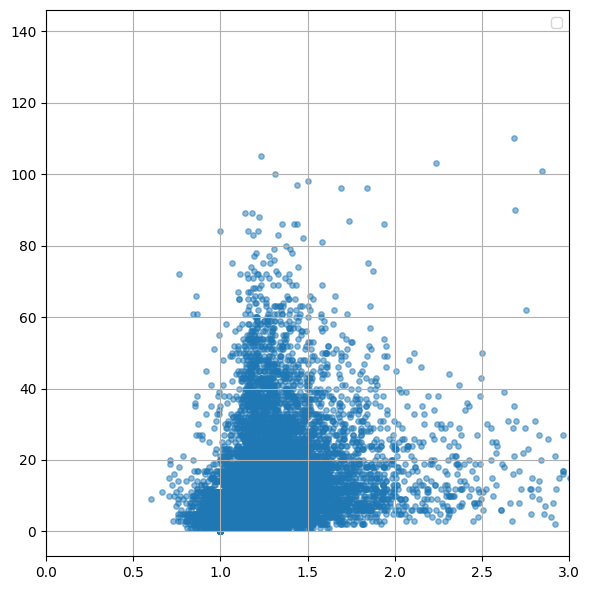

In [7]:
plt.figure(figsize=(6,6))
plt.scatter(np.array(w_true_list) / np.array(w0_solution_list), n_matches, s=15, alpha=0.5)

plt.legend()
plt.grid(True)
plt.xlim(0, 3)
plt.tight_layout()
plt.show()

len(df) = 19542
len(df) = 286
Pearson correlation = 0.980


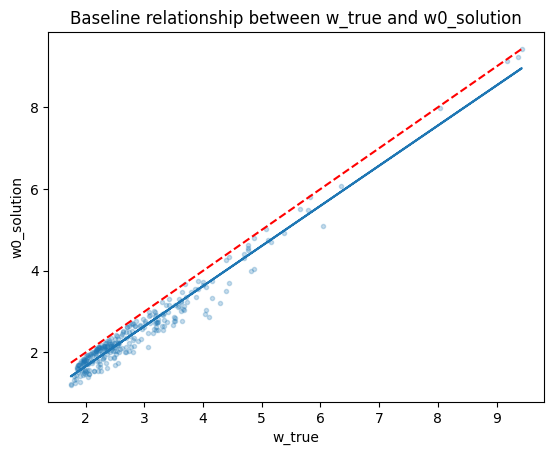

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

df = pd.DataFrame({
    "w_true": w_true_list,
    "w0_solution": w0_solution_list,
    "n_win": n_win,
    "n_loss": n_loss,
    "n_matches": n_matches,
    "player_name": player_name_list
})
# remove all rows where w_true devided by w0_solution < 1 and w_true devided by w0_solution > 1.5
print(f"{len(df) = }")
df = df[(df["w_true"] / df["w0_solution"] >= 1) & (df["w_true"] / df["w0_solution"] <= 1.5)]
# remove all rows where n_matches == 0
df = df[(df["n_matches"] == 1) & (df["n_win"] == 1)]
print(f"{len(df) = }")

# Quick sanity-check
assert not df.isna().any().any(), "Missing values will break regressions"
r = np.corrcoef(df["w_true"], df["w0_solution"])[0, 1]
print(f"Pearson correlation = {r:.3f}")

X = df[["w_true"]].values
y = df["w0_solution"].values

lin1 = LinearRegression().fit(X, y)
plt.scatter(df["w_true"], df["w0_solution"], alpha=0.25, marker=".")
plt.plot(X, lin1.predict(X))
# plot x=y line
plt.plot([df["w_true"].min(), df["w_true"].max()], [df["w_true"].min(), df["w_true"].max()],
         color="red",
         linestyle="--",
         label="y=x")
plt.xlabel("w_true")
plt.ylabel("w0_solution")
plt.title("Baseline relationship between w_true and w0_solution")
plt.show()


In [9]:
df

,w_true,w0_solution,n_win,n_loss,n_matches,player_name
2,3.235,2.545126,1,0,1,Dimo Hristov
169,2.796,2.726951,1,0,1,Pius von*Rotz
197,1.754,1.206113,1,0,1,Vito Fortunato
282,2.820,2.156062,1,0,1,Marc Läuchli
286,2.320,2.157414,1,0,1,Valentin Eitzinger
...,...,...,...,...,...,...
19177,2.240,1.708861,1,0,1,Hannes Keller
19205,3.873,3.348632,1,0,1,Kevin Stoudmann
19267,1.974,1.800771,1,0,1,Urs Trütsch
19320,2.018,1.728353,1,0,1,Gion -*Clau*Schuoler


In [10]:
player_dfs[("Ciril","Eberling")]

,adversaryFirstname,adversaryLastname,playerWinnerCode,adversary.classification,rank,adversary.competitionValue4L,Asr_AdversaryValue_f
date,,,,,,,
2024-09-01 13:51:37.094,Julius,Schäli,S,R7,None,1.936,0
2024-08-24 13:51:37.084,Michael,Baly,S,R6,None,3.233,0
2024-06-22 12:00:00.000,Lars,Aellig,S,R6,None,3.800,0
2024-06-07 12:00:00.000,Wiktor,Kaluzny,S,R8,None,1.249,0
2024-06-05 00:00:00.000,Julius,Schäli,S,R7,None,1.936,0
2024-05-12 12:00:00.000,Claudio,Imfeld,S,R5,None,4.511,0


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

predictors = ["w_true", "n_win", "n_loss", "n_matches"]         
predictors = ["w_true", "n_matches"]         
predictors = ["w_true"]         
X_train, X_test, y_train, y_test = train_test_split(
    df[predictors], df["w0_solution"], test_size=0.2, random_state=2)
# X_train, X_test, y_train, y_test=df[predictors],df[predictors], df["w0_solution"], df["w0_solution"]
lin = LinearRegression().fit(X_train, y_train)
print("--- Linear Regression ---")
print("Coefficients (β):", dict(zip(predictors, lin.coef_)))
print("Intercept (β₀):",  lin.intercept_)
print("R² (train / test):",
      f"{lin.score(X_train, y_train):.3f} / {lin.score(X_test, y_test):.3f}")
print("RMSE (test):", np.sqrt(mean_squared_error(y_test, lin.predict(X_test))))
print("Mean absolute percentage error (test):",
        np.mean(np.abs((y_test - lin.predict(X_test)) / y_test)) * 100)
print("\n--- Polynomial Regression ---")
# polynomial regression degree 2
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
lin_poly = LinearRegression().fit(X_poly, y_train)
print("coefficients (β):", dict(zip(poly.get_feature_names_out(predictors), lin_poly.coef_)))
print("intercept (β₀):", lin_poly.intercept_)
print("R² (train / test):",
      f"{lin_poly.score(X_poly, y_train):.3f} / {lin_poly.score(poly.transform(X_test), y_test):.3f}")
print("RMSE (test):", np.sqrt(mean_squared_error(y_test, lin_poly.predict(poly.transform(X_test)))))
print("Mean absolute percentage error (test):",
        np.mean(np.abs((y_test - lin_poly.predict(poly.transform(X_test))) / y_test)) * 100)

--- Linear Regression ---
Coefficients (β): {'w_true': np.float64(1.0314438778639556)}
Intercept (β₀): -0.5311986613015218
R² (train / test): 0.967 / 0.966
RMSE (test): 0.23583840804777012
Mean absolute percentage error (test): 5.501037558148452

--- Polynomial Regression ---
coefficients (β): {'1': np.float64(0.0), 'w_true': np.float64(0.9007485202068095), 'w_true^2': np.float64(0.011984372893535489)}
intercept (β₀): -0.2211731075966492
R² (train / test): 0.968 / 0.966
RMSE (test): 0.23790347599257752
Mean absolute percentage error (test): 5.495381545738021
